### Building Chatbot With Multiple Tools Using Langgraph

#### Aim

Create a chatbot with tool capabilities from arxiv, wikipedia,search and some functions


In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [2]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

In [3]:
arxiv.invoke("attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [4]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

In [5]:
wiki.invoke("What is machine learning?")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [6]:
from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env.

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["Groq_API_KEY"]=os.getenv("Groq_API_Key")

In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily= TavilySearchResults()


C:\Users\gakum\AppData\Local\Temp\ipykernel_3484\808923814.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily= TavilySearchResults()


In [8]:
tavily.invoke("Tell me about machine learning")

[{'title': 'Machine learning, explained | MIT Sloan',
  'url': 'https://mitsloan.mit.edu/ideas-made-to-matter/machine-learning-explained',
  'content': 'What is machine learning?\n\nMachine learning is a subfield of artificial intelligence, which is broadly defined as the capability of a machine to imitate intelligent human behavior. Artificial intelligence systems are used to perform complex tasks in a way that is similar to how humans solve problems. [...] When companies today deploy artificial intelligence programs, they are most likely using machine learning —so much so that the terms are often used interchangeably, and sometimes ambiguously. Machine learning is a subfield of artificial intelligence that gives computers the ability to learn without explicitly being programmed. [...] open share links close share links\nMachine learning is behind chatbots and predictive text, language translation apps, the shows Netflix suggests to you, and how your social media feeds are presented. 

In [9]:
tools=[arxiv, wiki, tavily]

In [10]:
from langchain_groq import ChatGroq

groq_llm=ChatGroq(model="qwen/qwen3-32b")

llm_with_tools=groq_llm.bind_tools(tools)

In [ ]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content="tell me about attentions is all you need reasearch paper")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about the "Attention is All You Need" research paper. Let me recall what that paper is about. I think it introduced the Transformer model, which uses self-attention mechanisms. But I need to make sure I get the details right.\n\nFirst, I should check if the paper is available on arXiv. The user mentioned "research paper," so the arXiv function would be appropriate here. The paper\'s title is likely "Attention Is All You Need" by Vaswani et al. The authors might include some well-known researchers in NLP. The key contributions are the Transformer architecture, self-attention, and position-wise feed-forward networks. The paper was published in 2017, I believe, at NeurIPS.\n\nWait, the user might want the key points, like how the Transformer works, its components like encoder-decoder layers, positional encoding, and the advantages over RNNs and CNNs. Also, the performance on tasks like machine translat

In [13]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]
    

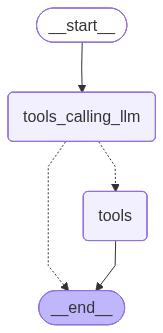

In [16]:
### Entire chatbot with LangGraph
from IPython.display import Image,display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


## Node Defintion
def tool_calling_llm(state:State):
    return {"messages":llm_with_tools.invoke(state["messages"])}

##Build Graph
graph=StateGraph(State)
graph.add_node("tools_calling_llm",tool_calling_llm)
graph.add_node("tools",ToolNode(tools))

graph.add_edge(START,"tools_calling_llm")
graph.add_conditional_edges("tools_calling_llm",tools_condition)
graph.add_edge("tools", END)

builder=graph.compile()

display(Image(builder.get_graph().draw_mermaid_png()))






In [20]:
messages=builder.invoke({"messages":HumanMessage(content="what is machine learning?")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is machine learning?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (qywwf5rzs)
 Call ID: qywwf5rzs
  Args:
    query: Machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
